## Directory files parser

#### Bandai namco

In [1]:
import os

def listBvhFiles(path:str) -> list[str]:
    result = []
    for item in os.listdir(path):
        itemPath = os.path.join(path, item)
        if os.path.isdir(itemPath): result.extend(listBvhFiles(itemPath))
        elif item.endswith('.bvh'): result.append(itemPath)
    return result

# getting all files ins the repository extracting labels
dataSetPath = '.\\Bandai-Namco-Research-Motiondataset\\dataset'
fileList:list[tuple[str, list[str]]] = []

for item in listBvhFiles(dataSetPath):
    fileName = item.split('\\')[-1]
    labels = fileName.split('_')[:-1]
    fileList.append((item, labels))

print(f'Files: {len(fileList)}')
# for f in fileList: print(f)

Files: 3077


## Motion featue extraction

In [2]:
import bvhio
import numpy
import glm

file = fileList[163]; print(file[1])
root = bvhio.read(file[0])
root = root.filter('Hips')[0].clearParent()
root.Scale = glm.vec3(0.01)
root.Position *= root.Scale
root.printTree()

['dataset-1', 'walk', 'normal']
Hips
+- Spine
|  +- Chest
|     +- Neck
|     |  +- Head
|     +- Shoulder_L
|     |  +- UpperArm_L
|     |     +- LowerArm_L
|     |        +- Hand_L
|     +- Shoulder_R
|        +- UpperArm_R
|           +- LowerArm_R
|              +- Hand_R
+- UpperLeg_L
|  +- LowerLeg_L
|     +- Foot_L
|        +- Toes_L
+- UpperLeg_R
   +- LowerLeg_R
      +- Foot_R
         +- Toes_R


#### Extract local & world data & more features

In [3]:
hierarchyData = []
layout = root.layout()
jointCount = len(layout)

for frame in range(len(root.Keyframes)):
    root.readPose(frame)
    rootWorldPosition = root.pointToWorld((0,0,0))

    frameData = []
    for joint, index, depth in layout:
        frameData.append([
            joint.RightLocal,                                      # 00 X-dir local
            joint.UpLocal,                                         # 01 Y-dir local
            joint.ForwardLocal,                                    # 02 Z-dir local
            joint.RightWorld,                                      # 03 X-dir world
            joint.UpWorld,                                         # 04 Y-dir world
            joint.ForwardWorld,                                    # 05 Z-dir world
            joint.Position,                                        # 06 Pos local
            joint.pointToWorld((0,0,0)),                           # 07 Pos world
            rootWorldPosition - joint.pointToWorld((0,0,0)),       # 08 Pos hips
        ])
    hierarchyData.append(frameData)

# (frame, type, joint, XYZ)
hierarchyData = numpy.array(hierarchyData)                                              # convert to numpy
hierarchyData = numpy.moveaxis(hierarchyData, 2, 1)                                     # switch joints and types

# calculating averages and append them as new 'joint'
averageData = numpy.average(hierarchyData, axis=2, keepdims=True)                       # average data
averageData[:, :6] /= numpy.linalg.norm(averageData[:, :6], axis=-1, keepdims=True)     # normalise directional data
hierarchyData = numpy.append(hierarchyData, averageData, axis=2)                        # append to extratex data
print(f'{hierarchyData.shape} - Hierarchy data with averages')                          # [Frame, feature, joint, XYZ] where joint -> 00-21 joints, 22 average of all joints

# plit into positions and directions because calculations will diff from now on
dirData = hierarchyData[:, :6, :, :]
posData = hierarchyData[:, 6:, :, :]
print(f'{dirData.shape} - Directional')
print(f'{posData.shape} - Positional')


(195, 9, 22, 3) - Hierarchy data with averages
(195, 6, 22, 3) - Directional
(195, 3, 22, 3) - Positional


In [58]:
dirDiffData = numpy.split(dirData, 3, axis=1)                                           # split into 3x3 matrices --> http://www.boris-belousov.net/2016/12/01/quat-dist/
dirDiffData = numpy.moveaxis(numpy.array(dirDiffData), 0, 3)                            # convert lists into numpy again
dirDiffData = numpy.moveaxis(dirDiffData, -1, -2) * numpy.roll(dirDiffData, 1, axis=0)  # calc diferential rotation matrix: D = A*xB
dirDiffData = numpy.arccos((numpy.trace(dirDiffData, axis1=-1, axis2=-2) - 1) / 2)      # get rotational change in radians
dirDiffData[:1] = 0                                                                     # first element do not have any valid data for those calculations

dirAccData = numpy.roll(dirDiffData, 1, axis=0) - dirDiffData                           # calc 'torque' of rotational change
dirAccData[:2] = 0                                                                      # first tow element do not have any valid data for those calculations
dirDiffData = numpy.stack((dirDiffData, dirAccData), axis=-1)                           # combine changes and torques
print(f'{dirDiffData.shape} - Changes and torques')                                     # [Frame, local | world, joint, change | torque]

dirEnergyData = dirDiffData[:, :, :21, 1]                                               # only joint torques are considered for energy
dirEnergyData = numpy.abs(dirEnergyData)                                                # all torque directions are considered as energy
dirEnergyData = numpy.sum(dirEnergyData, axis=2)                                        # sum all energies
print(f'{dirEnergyData.shape} - Energy')                                                # [Frame, local | world, energy]


(195, 2, 22, 2) - Changes and torques
(195, 2) - Energy


In [59]:
posDiffData = posData - numpy.roll(posData, 1, axis=0)                                  # get change in positions
posDiffNormData = numpy.linalg.norm(posDiffData, axis=-1, keepdims=True)                # get length of change in positions
posDiffNormData = numpy.where(posDiffNormData == 0, 1, posDiffNormData)                 # avoid 0-division if there is no change
posDiffData /= posDiffNormData                                                          # normalise change to get the trajectory of change
posDiffData = numpy.append(posDiffData, posDiffNormData, axis=-1)                       # include length of change to not lose information
posDiffData[:1] = 0                                                                     # first element do not have any valid data for those calculations

posAccData = numpy.array(posDiffData[:, : ,:, -1:])                                     # consider only change of velocity strength, keep last dim for future append
posAccData = numpy.roll(posAccData, 1, axis=0) - posAccData                             # get change of velocity
posAccData[:2] = 0                                                                      # first tow element do not have any valid data for those calculations

posDiffData = numpy.append(posDiffData, posAccData, axis=-1)                            # combine changes and accelerations
print(f'{posDiffData.shape} - Changes and accelerations')                               # [Frame, local | world | hips, joint, XYZ-dir, length, acceleration]

posEnergyData = posDiffData[:, :, :21, -1]
posEnergyData = numpy.abs(posEnergyData)                                                # acceleration and decelerations is considered as energy used
posEnergyData = numpy.sum(posEnergyData, axis=2)                                        # sum all energies for the keyframe
print(f'{posEnergyData.shape} - Energy')                                                # [Frame, local | world | hips, energy]

(195, 3, 22, 5) - Changes and accelerations
(195, 3) - Energy


#### Plot data

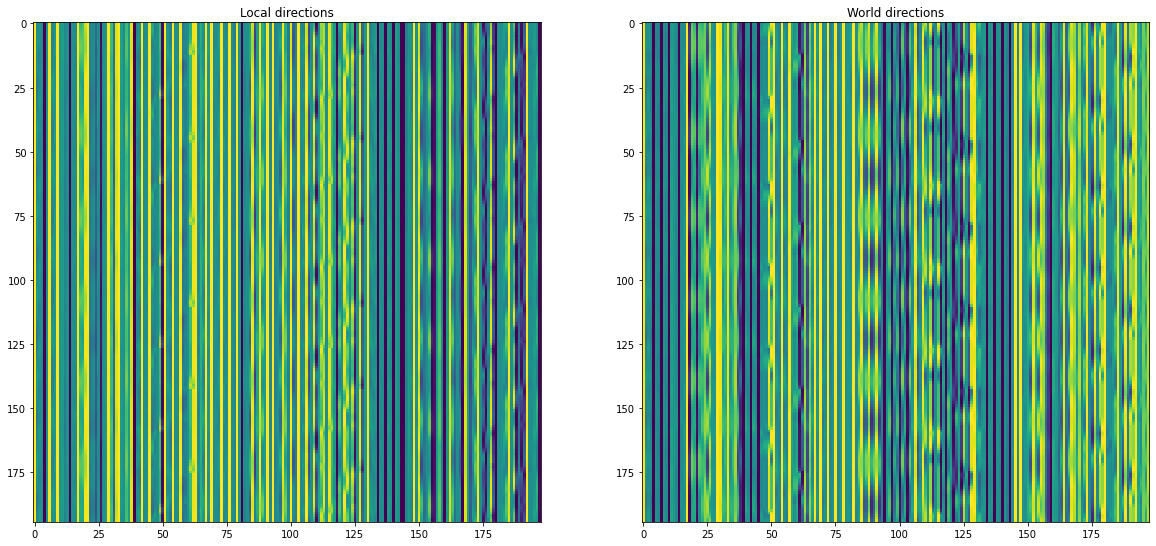

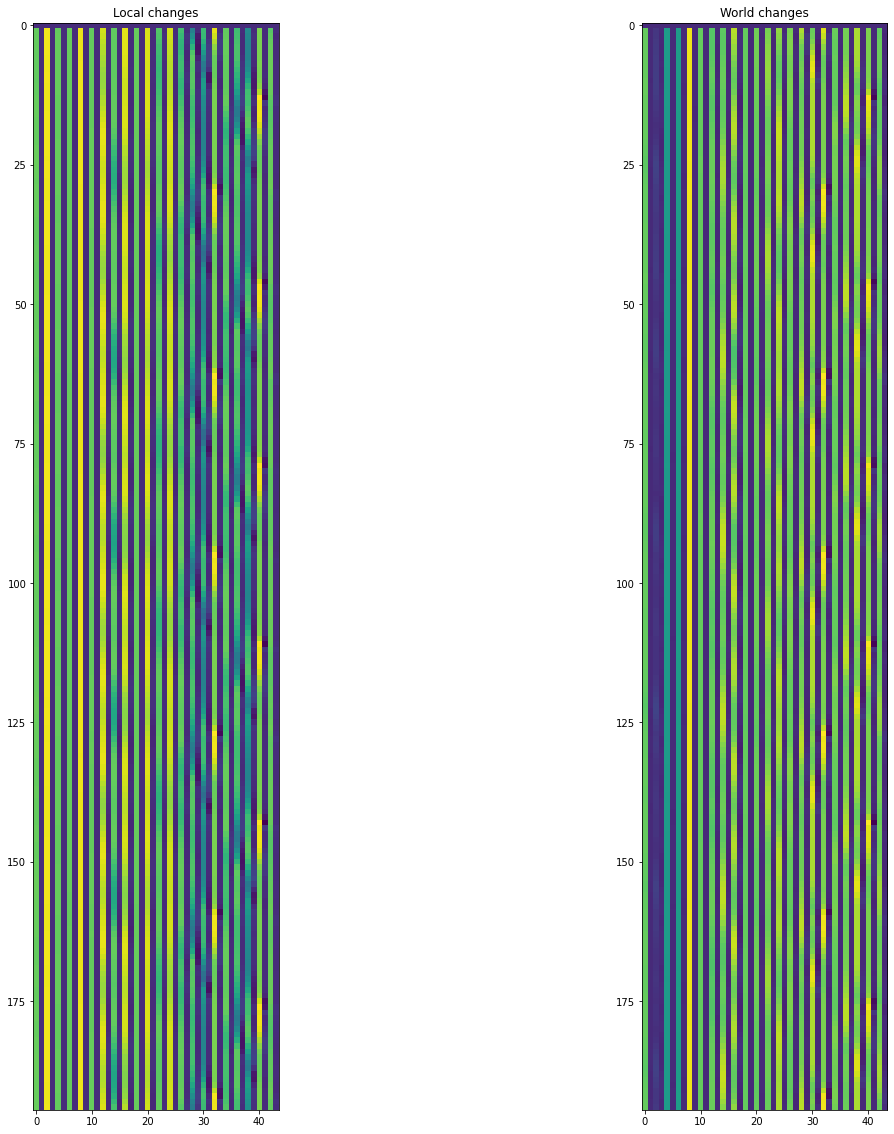

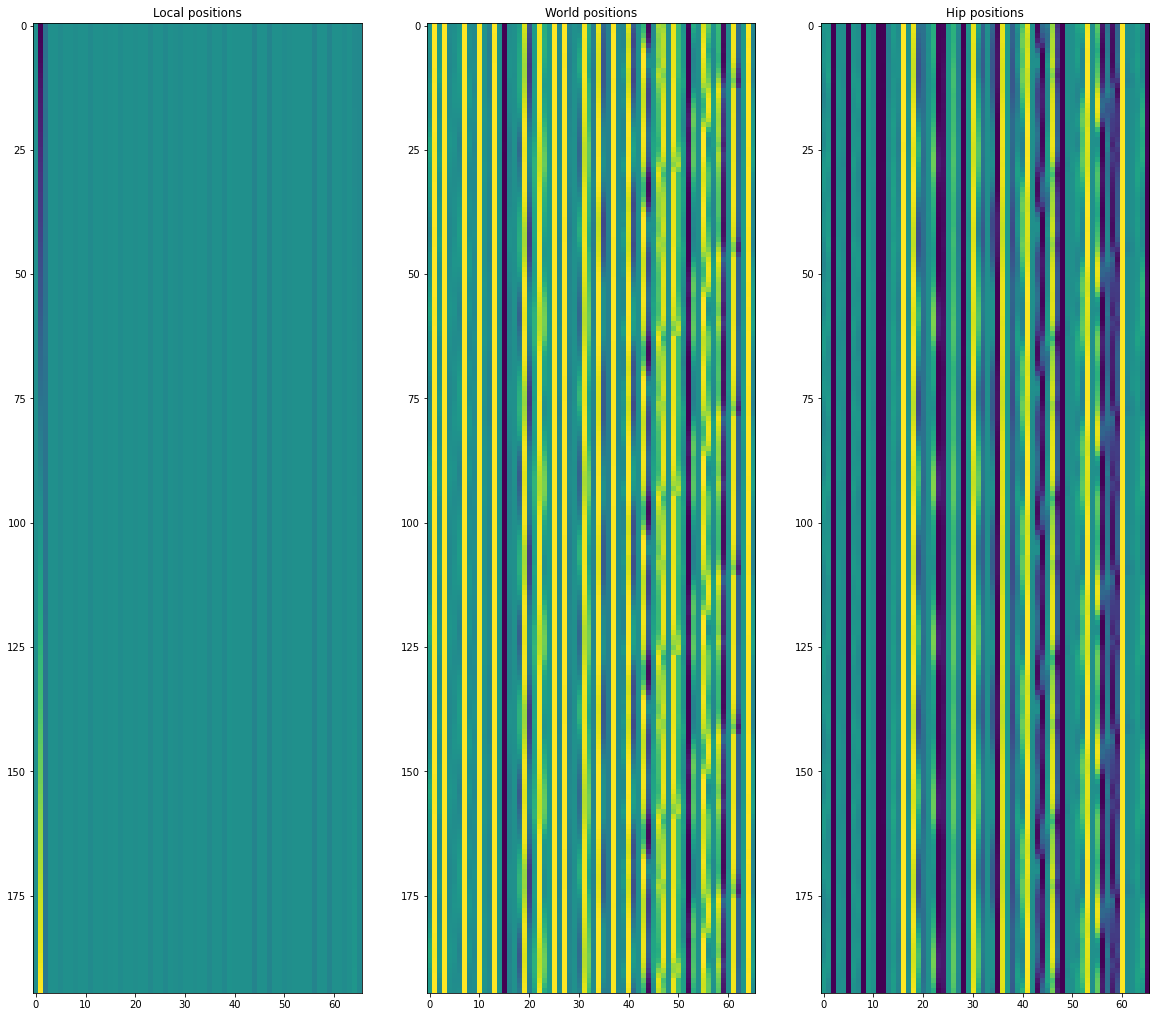

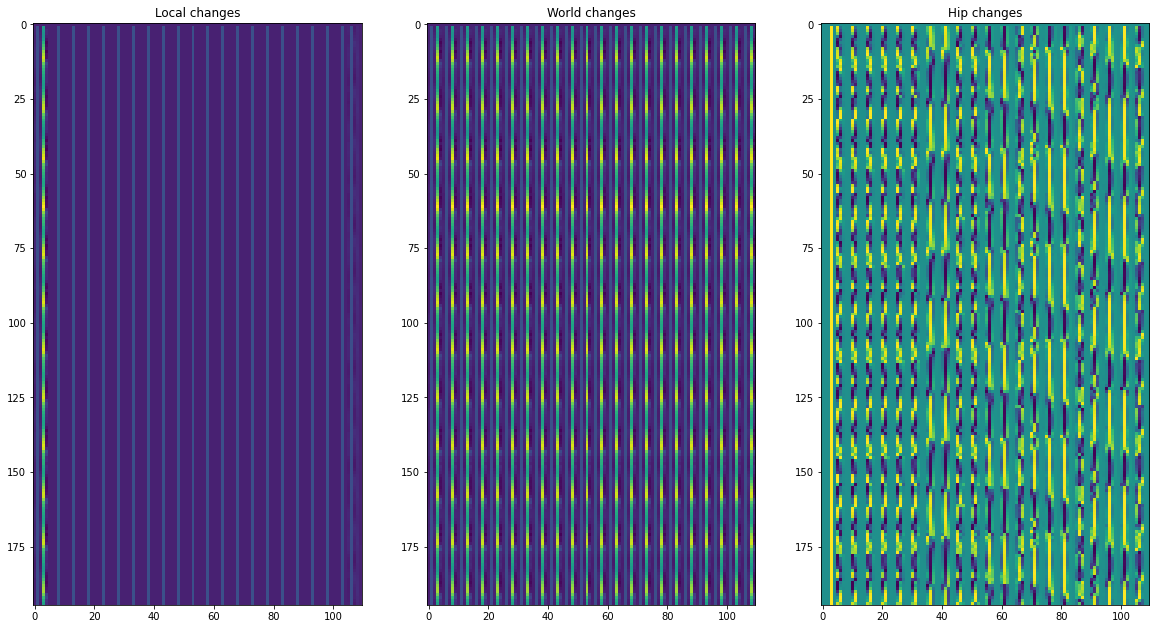

In [80]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(20, 20))
# [Frame, feature, joint, XYZ]
axs[0].set_title('Local directions')
axs[0].imshow(numpy.reshape(dirData[:, 0:3], (dirData.shape[0], -1)), interpolation='nearest')
axs[1].set_title('World directions')
axs[1].imshow(numpy.reshape(dirData[:, 3:6], (dirData.shape[0], -1)), interpolation='nearest')
plt.show()

fig, axs = plt.subplots(1,2, figsize=(20, 20))
# [Frame, local | world, joint, change | torque]
axs[0].set_title('Local changes')
axs[0].imshow(numpy.reshape(dirDiffData[:, 0], (dirDiffData.shape[0], -1)), interpolation='nearest')
axs[1].set_title('World changes')
axs[1].imshow(numpy.reshape(dirDiffData[:, 1], (dirDiffData.shape[0], -1)), interpolation='nearest')
plt.show()

fig, axs = plt.subplots(1,3, figsize=(20, 20))
# [Frame, feature, joint, XYZ]
axs[0].set_title('Local positions')
axs[0].imshow(numpy.reshape(posData[:, 0], (dirData.shape[0], -1)), interpolation='nearest')
axs[1].set_title('World positions')
axs[1].imshow(numpy.reshape(dirData[:, 1], (dirData.shape[0], -1)), interpolation='nearest')
axs[2].set_title('Hip positions')
axs[2].imshow(numpy.reshape(dirData[:, 2], (dirData.shape[0], -1)), interpolation='nearest')
plt.show()

fig, axs = plt.subplots(1,3, figsize=(20, 20))
# [Frame, local | world | hips, joint, XYZ-dir, length, acceleration]
axs[0].set_title('Local changes')
axs[0].imshow(numpy.reshape(posDiffData[:, 0], (dirData.shape[0], -1)), interpolation='nearest')
axs[1].set_title('World changes')
axs[1].imshow(numpy.reshape(posDiffData[:, 1], (dirData.shape[0], -1)), interpolation='nearest')
axs[2].set_title('Hip changes')
axs[2].imshow(numpy.reshape(posDiffData[:, 2], (dirData.shape[0], -1)), interpolation='nearest')
plt.show()